# Imports

In [112]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

# Parameters

In [113]:
PRM_PCT_TST = 0.2 # Percantage of samples for the test set
PRM_PCT_VLD_FROM_TRN = 0.2 # Percantage of samples from the complete training set for the validation set
PRM_RND = 23 # Random seed

## Read the data

In [114]:
df = pd.read_csv('stroke_data.csv')

## Dataset outline

### Observe a few rows

In [115]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,Female,80.0,0,1,Yes,Self-employed,Urban,67.45,25.6,never smoked,0
1,4,Female,37.0,0,0,Yes,Private,Rural,82.15,24.3,smokes,0
2,6,Female,21.0,0,0,No,Private,Urban,75.73,NaN,never smoked,0
3,7,Female,44.0,0,0,Yes,Private,Urban,222.75,19.6,never smoked,0
4,8,Female,79.0,0,0,Yes,Private,Urban,99.23,25.1,NaN,0


### Get the shape of the dataset

In [116]:
df.shape

(43400, 12)

### Make sure that each ID shows only once (i.e., no need to aggregate, not a time series per person)

In [117]:
len(df['id'].unique())

43400

## Partition the data

Training / Test sets

In [118]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('stroke', axis = 1) # X
    ,df['stroke'] # y
    ,test_size = PRM_PCT_TST
    ,random_state = PRM_RND
    ,shuffle = True
    ,stratify = None
)

Sub-training / Validation sets

In [119]:
X_sub_train, X_validation, y_sub_train, y_validation = train_test_split(
    X_train # X
    ,y_train # y
    ,test_size = PRM_PCT_VLD_FROM_TRN
    ,random_state = PRM_RND
    ,shuffle = True
    ,stratify = None
)

## Explore the training set

### Class distribution

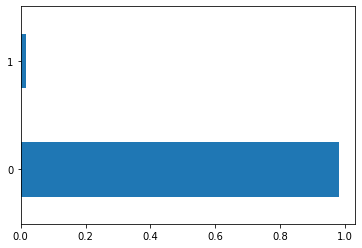

In [120]:
y_sub_train.value_counts(
    dropna = False
    ,normalize = True
).plot.barh()

# --> Highly imbalanced (approximately 98% - 2%)
# --> Consider resampling during training

### Overview of (potential) predictors

In [121]:
X_sub_train.shape # Count of rows & columns

(27776, 11)

In [122]:
# Identify features with missing values
# Make sure that the data type is correct
X_sub_train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27776 entries, 19365 to 25821
Data columns (total 11 columns):
id                   27776 non-null int64
gender               27776 non-null object
age                  27776 non-null float64
hypertension         27776 non-null int64
heart_disease        27776 non-null int64
ever_married         27776 non-null object
work_type            27776 non-null object
Residence_type       27776 non-null object
avg_glucose_level    27776 non-null float64
bmi                  26827 non-null float64
smoking_status       19267 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 2.5+ MB


In [123]:
X_sub_train.describe() # Statistics regrading the numeric features

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
count,27776.000000,27776.000000,27776.000000,27776.000000,27776.000000,26827.000000
mean,36373.908950,42.140514,0.093750,0.048063,104.217291,28.587457
std,21044.229304,22.540124,0.291486,0.213903,42.976015,7.728739
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.300000
25%,18070.000000,24.000000,0.000000,0.000000,77.400000,23.200000
50%,36430.500000,44.000000,0.000000,0.000000,91.450000,27.700000
75%,54532.250000,60.000000,0.000000,0.000000,111.760000,32.800000
max,72939.000000,82.000000,1.000000,1.000000,291.050000,89.100000


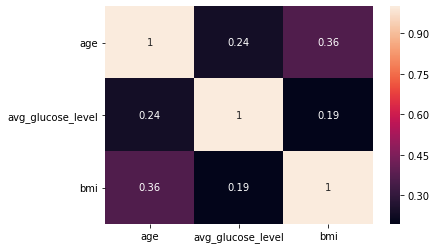

In [124]:
corrMatrix = X_sub_train[['age', 'avg_glucose_level', 'bmi']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

# --> No strong (linear) correlation found among the numeric variables

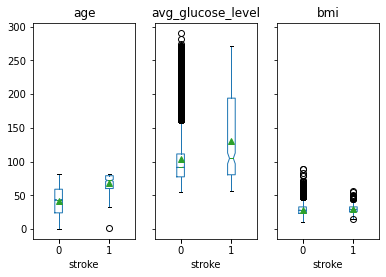

In [125]:
pd.concat(
    [X_sub_train, y_sub_train]
    ,axis = 1
    ,sort = False
     ).boxplot(
        column = ['age', 'avg_glucose_level', 'bmi']
        ,by = 'stroke'
        ,layout = (1,3)
        ,grid = False
        ,showmeans = True
        ,notch = True
        ,vert = True
    )
plt.suptitle('')
plt.show()

In [126]:
X_sub_train['gender'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# Relatively balanced, makes sense
# --> Keep 'Other', might be difficult to infer on the validation / test set

Female    0.591806
Male      0.407834
Other     0.000360
Name: gender, dtype: float64

In [127]:
X_sub_train['hypertension'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# --> The distribution seems realistic

0    0.90625
1    0.09375
Name: hypertension, dtype: float64

In [128]:
X_sub_train['heart_disease'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# --> The distribution seems realistic

0    0.951937
1    0.048063
Name: heart_disease, dtype: float64

In [129]:
X_sub_train['ever_married'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# --> The distribution seems realistic

Yes    0.641813
No     0.358187
Name: ever_married, dtype: float64

In [130]:
X_sub_train['work_type'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# --> The distribution seems realistic

Private          0.573409
Self-employed    0.154846
children         0.143001
Govt_job         0.125072
Never_worked     0.003672
Name: work_type, dtype: float64

In [131]:
X_sub_train['Residence_type'].value_counts(
    dropna = False
    ,normalize = True
)#.plot.barh()

# --> The distribution seems OK, although probably not from Israel (biased towards 'Rural')

Urban    0.503312
Rural    0.496688
Name: Residence_type, dtype: float64

In [132]:
pd.crosstab(
    X_sub_train['ever_married']
    ,X_sub_train['hypertension']
    ,dropna = False
    ,normalize = 'index'
)

# Interesting...

hypertension,0,1
ever_married,,
No,0.974972,0.025028
Yes,0.867897,0.132103


### Preliminary insights, questions and decisions

Insights
* __Age__: Min seems questionable yet OK
* __gender__:                 
* __Hypertension__: [Possibly stands for](https://en.wikipedia.org/wiki/Hypertension#:~:text=Hypertension%20(HTN%20or%20HT)%2C,typically%20does%20not%20cause%20symptoms.) "HT / HTN / High Blood Pressure / HBP"; The range seems like [0, 1], so probably boolean
* __Heart_disease__: Probably boolean
* __ever_married__: 
* __work_type__: 
* __Residence_type__: 
* __Avg_glucose_level__: Probably in [terms of](https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html) mg/dL rather than mmol/L; Levels above 200 may indicate diabetes
* __bmi__: Body Mass Index, levels above 40 [indicate](https://en.wikipedia.org/wiki/Body_mass_index) Class III Obesity (Very severely obese), here we have much more; also 949 missing values (~3.4%)
* __smoking_status__: 8,509 missing values (~30.6%)

Questions
* Are babies taken into account? Some values are really low

Decisions
* bmi: Clip at 40 (upper bound)
* bmi: Remove missing values from the training set, impute in the validation & test sets using the training's median
* smoking_status: Check if missing implies 'non-smoking'
* All of the features have some variability (i.e., they are not constant), so none can be disqualified due to near-zero variance
* The feature set is quite small and intuitively correlated with the target, so no feature selection is undertaken
* __put all of the insights into a preprocessing function__


In [133]:
# Distribution
X_sub_train['smoking_status'].value_counts(dropna = False)

never smoked       10272
NaN                 8509
formerly smoked     4814
smokes              4181
Name: smoking_status, dtype: int64

In [134]:
# Look for unreal combinations, e.g., baby smokers
X_sub_train[['age', 'smoking_status']].copy().sort_values(
    by = 'age'
    ,ascending = True
).head(n = 15)

,age,smoking_status
34498,0.08,NaN
7837,0.08,NaN
25940,0.08,NaN
21869,0.08,NaN
4855,0.08,NaN
17933,0.08,NaN
20610,0.08,NaN
24294,0.08,NaN
36914,0.08,NaN
6493,0.08,NaN


In [135]:
# What is the age distribution for unknown smoking status?
X_sub_train[X_sub_train['smoking_status'].isnull()]['age'].value_counts(bins=10)

(-0.00292, 8.272]    2542
(8.272, 16.464]      1291
(16.464, 24.656]      709
(49.232, 57.424]      660
(32.848, 41.04]       649
(41.04, 49.232]       619
(24.656, 32.848]      543
(73.808, 82.0]        530
(57.424, 65.616]      521
(65.616, 73.808]      445
Name: age, dtype: int64

### Parameters for preprocessing

In [136]:
PRM_BMI_MAX = 40 # for upper clipping
PRM_BMI_MEDIAN = X_sub_train['bmi'].median(skipna = True) # for imputing missing values
PRM_MAX_AGE_FOR_YOUNG = 15 # age, below which a person would be considered as 'never smoked'

PRM_CATEGORICAL_FEATURES_TO_ENCODE = ['gender', 'work_type', 'Residence_type', 'smoking_status']
# PRM_CONTINUOUS_FEATURES_TO_SCALE = ['age', 'avg_glucose_level', 'bmi']
PRM_BOOLEAN_FEATURES = ['hypertension', 'heart_disease', 'ever_married']

### Young persons have most probably never really smoked, others are added to a new 'unknown' category

In [137]:
def replace_missing_smoking_status(x):
    if pd.isna(x['smoking_status']):
        if x['age'] < PRM_MAX_AGE_FOR_YOUNG:
            return 'never smoked'
        else:
            return 'unknown'
    else:
        return x['smoking_status']

## Function to preprocess a dataset

In [138]:
def preprocess_dataset(df_x, df_y, partition_type):
    
    # Remove the 'id' column
    df_x = df_x.drop(
        labels = ['id']
        ,axis = 1
        ,inplace = False
    )
    
    # Clip the BMI at 40 (upper bound)
    df_x['bmi'] = df_x['bmi'].clip(
        upper = PRM_BMI_MAX
        ,inplace = False
    )
    
    # Convert to boolean - predictors
    df_x['hypertension'] = pd.Series(df_x['hypertension'] == 1)
    df_x['heart_disease'] = pd.Series(df_x['heart_disease'] == 1)
    df_x['ever_married'] = pd.Series(df_x['ever_married'] == 'Yes')
    
    # Convert to boolean - Stroke (class)
    df_y = pd.Series(df_y == 1)
    
    # Handle missing values
    
    # Smoking status
    df_x['smoking_status'] = df_x.apply(replace_missing_smoking_status, axis=1)
    
    # BMI
    if (partition_type == 'training'):
        df_y = df_y[df_x['bmi'].notnull()] # first drop from y
        df_x = df_x[df_x['bmi'].notnull()] # then drop from X
    else: # validation or test sets
        df_x['bmi'].fillna(
            value = PRM_BMI_MEDIAN
            ,inplace = True
        )
        
    return df_x, df_y

# Training

In [139]:
# Preprocess the training set
X_sub_train, y_sub_train = preprocess_dataset(X_sub_train, y_sub_train, 'training')

In [140]:
# Validate expected changes
X_sub_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26827 entries, 19365 to 25821
Data columns (total 10 columns):
gender               26827 non-null object
age                  26827 non-null float64
hypertension         26827 non-null bool
heart_disease        26827 non-null bool
ever_married         26827 non-null bool
work_type            26827 non-null object
Residence_type       26827 non-null object
avg_glucose_level    26827 non-null float64
bmi                  26827 non-null float64
smoking_status       26827 non-null object
dtypes: bool(3), float64(3), object(4)
memory usage: 1.7+ MB


## Prepare the training set for LightGBM

In [141]:
# labels
y_sub_train_LGBM = y_sub_train.values

# Predictors

lb_gender = LabelEncoder()
lb_work_type = LabelEncoder()
lb_Residence_type = LabelEncoder()
lb_smoking_status = LabelEncoder()
X_sub_train['gender'] = lb_gender.fit_transform(X_sub_train['gender'])
X_sub_train['work_type'] = lb_work_type.fit_transform(X_sub_train['work_type'])
X_sub_train['Residence_type'] = lb_Residence_type.fit_transform(X_sub_train['Residence_type'])
X_sub_train['smoking_status'] = lb_smoking_status.fit_transform(X_sub_train['smoking_status'])

# Change the type: Boolean to int
for col in PRM_BOOLEAN_FEATURES:
    X_sub_train[col] = 1 * X_sub_train[col]
    
X_sub_train_LGBM = X_sub_train.values

# LGBM-format dataset
train_data_LGBM = lgbm.Dataset(
    X_sub_train_LGBM
    ,label=y_sub_train_LGBM
    ,categorical_feature= PRM_CATEGORICAL_FEATURES_TO_ENCODE + PRM_BOOLEAN_FEATURES
    ,feature_name = X_sub_train.columns.tolist()
)

## Prepare the validation set for LightGBM

In [142]:
X_validation, y_validation = preprocess_dataset(X_validation, y_validation, 'validation')

In [143]:
# labels
y_validation_LGBM = y_validation.values

# Predictors
X_validation['gender'] = lb_gender.transform(X_validation['gender'])
X_validation['work_type'] = lb_work_type.transform(X_validation['work_type'])
X_validation['Residence_type'] = lb_Residence_type.transform(X_validation['Residence_type'])
X_validation['smoking_status'] = lb_smoking_status.transform(X_validation['smoking_status'])

# Change the type: Boolean to int
for col in PRM_BOOLEAN_FEATURES:
    X_validation[col] = 1 * X_validation[col]

X_validation_LGBM = X_validation.values

# LGBM-format dataset
validation_data_LGBM = lgbm.Dataset(
    X_validation_LGBM
    ,label=y_validation_LGBM
    ,reference = train_data_LGBM
    ,categorical_feature = PRM_CATEGORICAL_FEATURES_TO_ENCODE + PRM_BOOLEAN_FEATURES
    ,feature_name = X_validation.columns.tolist()
)

## Train a default LGBM classifier

In [144]:
LGBM_default_model = lgbm.train(
    {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': 'true',
        'verbose': 0
    },
    train_data_LGBM,
    valid_sets=validation_data_LGBM,
    early_stopping_rounds=10
)

[1]	valid_0's auc: 0.799723
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.812038
[3]	valid_0's auc: 0.821848
[4]	valid_0's auc: 0.824964
[5]	valid_0's auc: 0.822916
[6]	valid_0's auc: 0.818968
[7]	valid_0's auc: 0.817931
[8]	valid_0's auc: 0.818452
[9]	valid_0's auc: 0.819737
[10]	valid_0's auc: 0.821218
[11]	valid_0's auc: 0.820026
[12]	valid_0's auc: 0.819014
[13]	valid_0's auc: 0.816338
[14]	valid_0's auc: 0.817788
Early stopping, best iteration is:
[4]	valid_0's auc: 0.824964


C:\Users\Administrator\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


## Prepare the test set for LightGBM

In [145]:
X_test, y_test = preprocess_dataset(X_test, y_test, 'test')

In [146]:
# labels
y_test_LGBM = y_test.values

# Predictors
X_test['gender'] = lb_gender.transform(X_test['gender'])
X_test['work_type'] = lb_work_type.transform(X_test['work_type'])
X_test['Residence_type'] = lb_Residence_type.transform(X_test['Residence_type'])
X_test['smoking_status'] = lb_smoking_status.transform(X_test['smoking_status'])

# Change the type: Boolean to int
for col in PRM_BOOLEAN_FEATURES:
    X_test[col] = 1 * X_test[col]

X_test_LGBM = X_test.values

# LGBM-format dataset
test_data_LGBM = lgbm.Dataset(
    X_test_LGBM
    ,label=y_test_LGBM
    ,reference = train_data_LGBM
    ,categorical_feature = PRM_CATEGORICAL_FEATURES_TO_ENCODE + PRM_BOOLEAN_FEATURES
    ,feature_name = X_test.columns.tolist()
)

## Test the LightGBM default classifier

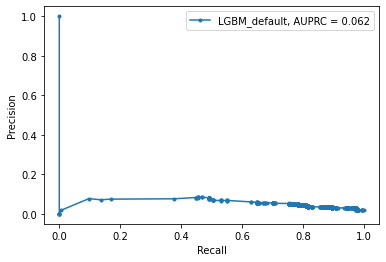

In [147]:
LGBM_default_precision, LGBM_default_recall, _ = precision_recall_curve(
    y_test
    ,LGBM_default_model.predict(X_test_LGBM)
)

plt.plot(LGBM_default_recall, LGBM_default_precision, marker='.', label=
         'LGBM_default, AUPRC = ' +\
         str(round(average_precision_score(y_test, LGBM_default_model.predict(X_test_LGBM)),3))
        )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### The performance is very poor, maybe due to the extreme class imbalance

# Train another LGBM model, based on a resampled (balanced) training set

In [148]:
y_sub_train.value_counts()

False    26432
True       395
Name: stroke, dtype: int64

In [149]:
# Concat X and y for later resampling
X_y_sub_train = pd.concat(
    [X_sub_train, y_sub_train]
    ,axis = 1
    ,sort = False
)

# Concat all 'False' and resampled 'True' training instances
X_y_sub_train = pd.concat(
    [
        X_y_sub_train[X_y_sub_train['stroke']==False]
        ,X_y_sub_train[X_y_sub_train['stroke']==True].sample(
            n = 26432
            ,replace = True
            ,random_state = PRM_RND
        )
    ]
    ,axis = 0
    ,sort = False
)

# Validate the class distribution
X_y_sub_train['stroke'].value_counts()

True     26432
False    26432
Name: stroke, dtype: int64

In [150]:
# Separate class from predictors
y_train_SAM = X_y_sub_train['stroke']
X_train_SAM = X_y_sub_train.drop('stroke', axis=1)

# labels
y_train_SAM_LGBM = y_train_SAM.values

X_train_SAM_LGBM = X_train_SAM.values

# LGBM-format dataset
train_data_SAM_LGBM = lgbm.Dataset(
    X_train_SAM_LGBM
    ,label=y_train_SAM_LGBM
    ,reference = train_data_LGBM
    ,categorical_feature = PRM_CATEGORICAL_FEATURES_TO_ENCODE + PRM_BOOLEAN_FEATURES
    ,feature_name = X_train_SAM.columns.tolist()
)

In [151]:
LGBM_SAM_model = lgbm.train(
    {
        'application': 'binary',
        'objective': 'binary',
        'metric': 'auc', 
        'is_unbalance': 'false',
        'verbose': 0
    },
    train_data_SAM_LGBM,
    valid_sets=validation_data_LGBM,
    early_stopping_rounds=10
)

C:\Users\Administrator\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.795695
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.817538
[3]	valid_0's auc: 0.826344
[4]	valid_0's auc: 0.827478
[5]	valid_0's auc: 0.832431
[6]	valid_0's auc: 0.833378
[7]	valid_0's auc: 0.833029
[8]	valid_0's auc: 0.832824
[9]	valid_0's auc: 0.837619
[10]	valid_0's auc: 0.835576
[11]	valid_0's auc: 0.834992
[12]	valid_0's auc: 0.835835
[13]	valid_0's auc: 0.834842
[14]	valid_0's auc: 0.835569
[15]	valid_0's auc: 0.837078
[16]	valid_0's auc: 0.836419
[17]	valid_0's auc: 0.837281
[18]	valid_0's auc: 0.837268
[19]	valid_0's auc: 0.83656
Early stopping, best iteration is:
[9]	valid_0's auc: 0.837619


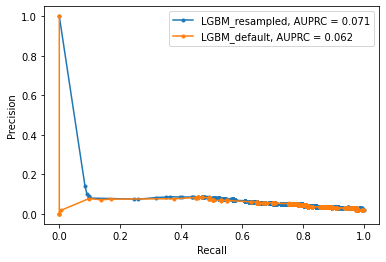

In [152]:
LGBM_SAM_precision, LGBM_SAM_recall, _ = precision_recall_curve(
    y_test
    ,LGBM_SAM_model.predict(X_test_LGBM)
)

plt.plot(LGBM_SAM_recall, LGBM_SAM_precision, marker='.', label=
         'LGBM_resampled, AUPRC = ' +\
         str(round(average_precision_score(y_test, LGBM_SAM_model.predict(X_test_LGBM)),3))
        )
plt.plot(LGBM_default_recall, LGBM_default_precision, marker='.', label=
         'LGBM_default, AUPRC = ' +\
         str(round(average_precision_score(y_test, LGBM_default_model.predict(X_test_LGBM)),3))
        )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### The performance is slightly better yet very poor, maybe due to model overfitting

## Apply the classifier to the validation set and look for differences

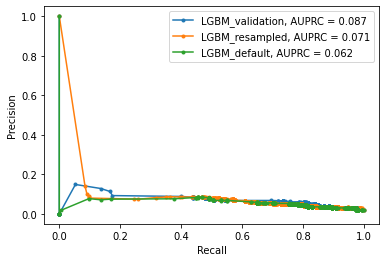

In [153]:
LGBM_validation_precision, LGBM_validation_recall, _ = precision_recall_curve(
    y_validation
    ,LGBM_default_model.predict(X_validation_LGBM)
)

plt.plot(LGBM_validation_recall, LGBM_validation_precision, marker='.', label=
         'LGBM_validation, AUPRC = ' +\
         str(round(average_precision_score(y_validation, LGBM_SAM_model.predict(X_validation_LGBM)),3))
        )
plt.plot(LGBM_SAM_recall, LGBM_SAM_precision, marker='.', label=
         'LGBM_resampled, AUPRC = ' +\
         str(round(average_precision_score(y_test, LGBM_SAM_model.predict(X_test_LGBM)),3))
        )
plt.plot(LGBM_default_recall, LGBM_default_precision, marker='.', label=
         'LGBM_default, AUPRC = ' +\
         str(round(average_precision_score(y_test, LGBM_default_model.predict(X_test_LGBM)),3))
        )
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

### The performance is slightly better on the validation set yet very poor, maybe hyper-parameter tuning would assist

In [154]:
# Ranges for hyper-parameter optimization
PRM_RANGE_FEATURE_FRACTION = np.arange(0.1, 1.1, 0.1) # speed, over-fitting
PRM_RANGE_MIN_DATA_IN_LEAF = np.arange(0.01, 0.11, 0.01) # Over-fitting

In [155]:
# Instantiate a data frame to keep track of the grid search
hyp_grid = pd.DataFrame(columns = ['feature_fraction', 'min_data_in_leaf', 'validation_AUPRC'])

# Separate class from predictors
y_train_SAM = X_y_sub_train['stroke']
X_train_SAM = X_y_sub_train.drop('stroke', axis=1)

# labels
y_train_SAM_LGBM = y_train_SAM.values

i=0
        
# Populate the grid search data frae
for ff in PRM_RANGE_FEATURE_FRACTION:
    for md in PRM_RANGE_MIN_DATA_IN_LEAF:
        
        # LGBM-format dataset
        train_data_SAM_LGBM = lgbm.Dataset(
            X_train_SAM_LGBM
            ,label=y_train_SAM_LGBM
            ,reference = train_data_LGBM
            ,categorical_feature = PRM_CATEGORICAL_FEATURES_TO_ENCODE + PRM_BOOLEAN_FEATURES
            ,feature_name = X_train_SAM.columns.tolist()
        )
        
        # Train a classifier
        LGBM_SAM_model = lgbm.train(
            {
                'application': 'binary',
                'objective': 'binary',
                'metric': 'auc', 
                'is_unbalance': 'false',
                'feature_fraction': ff, # grid - X axis
                'min_data_in_leaf': int(round(md*y_train_SAM.shape[0], 0)), # grid - y axis 
                'verbose': 0
            },
            train_data_SAM_LGBM,
            valid_sets=validation_data_LGBM,
            early_stopping_rounds=10
        )
        
        # Calculate the area under the precision-recall curve
        AUPRC = round(average_precision_score(y_validation, LGBM_SAM_model.predict(X_validation_LGBM)),3)
        
        # Create a temporary data frame
        temp_hyp_grid = pd.DataFrame(
            {
                'feature_fraction': ff
                ,'min_data_in_leaf': md
                ,'validation_AUPRC': AUPRC
            }
            ,index=[i]
        )
        
        # Add the temporary data into the grid search data frame
        hyp_grid = pd.concat(
            [hyp_grid, temp_hyp_grid]
            ,axis = 0
        )
        
        i = i+1

C:\Users\Administrator\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's auc: 0.584891
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.621668
[3]	valid_0's auc: 0.695634
[4]	valid_0's auc: 0.667755
[5]	valid_0's auc: 0.781932
[6]	valid_0's auc: 0.766099
[7]	valid_0's auc: 0.768115
[8]	valid_0's auc: 0.773471
[9]	valid_0's auc: 0.774854
[10]	valid_0's auc: 0.776051
[11]	valid_0's auc: 0.766548
[12]	valid_0's auc: 0.767777
[13]	valid_0's auc: 0.795699
[14]	valid_0's auc: 0.787828
[15]	valid_0's auc: 0.787662
[16]	valid_0's auc: 0.787523
[17]	valid_0's auc: 0.787336
[18]	valid_0's auc: 0.791052
[19]	valid_0's auc: 0.807259
[20]	valid_0's auc: 0.800881
[21]	valid_0's auc: 0.800827
[22]	valid_0's auc: 0.810052
[23]	valid_0's auc: 0.809682
[24]	valid_0's auc: 0.810021
[25]	valid_0's auc: 0.806502
[26]	valid_0's auc: 0.805496
[27]	valid_0's auc: 0.812725
[28]	valid_0's auc: 0.812659
[29]	valid_0's auc: 0.810597
[30]	valid_0's auc: 0.810518
[31]	valid_0's auc: 0.810587
[32]	valid_0's auc: 0.810505
[33]	valid_0's auc: 

[1]	valid_0's auc: 0.581222
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.627914
[3]	valid_0's auc: 0.708474
[4]	valid_0's auc: 0.687674
[5]	valid_0's auc: 0.803715
[6]	valid_0's auc: 0.794073
[7]	valid_0's auc: 0.795155
[8]	valid_0's auc: 0.796572
[9]	valid_0's auc: 0.797727
[10]	valid_0's auc: 0.79689
[11]	valid_0's auc: 0.787859
[12]	valid_0's auc: 0.787817
[13]	valid_0's auc: 0.810438
[14]	valid_0's auc: 0.804378
[15]	valid_0's auc: 0.804536
[16]	valid_0's auc: 0.803381
[17]	valid_0's auc: 0.803232
[18]	valid_0's auc: 0.80656
[19]	valid_0's auc: 0.820026
[20]	valid_0's auc: 0.81677
[21]	valid_0's auc: 0.815649
[22]	valid_0's auc: 0.823109
[23]	valid_0's auc: 0.824207
[24]	valid_0's auc: 0.824019
[25]	valid_0's auc: 0.822729
[26]	valid_0's auc: 0.822903
[27]	valid_0's auc: 0.828411
[28]	valid_0's auc: 0.827893
[29]	valid_0's auc: 0.826336
[30]	valid_0's auc: 0.825882
[31]	valid_0's auc: 0.825986
[32]	valid_0's auc: 0.825614
[33]	valid_0's auc: 0.8

[35]	valid_0's auc: 0.821882
[36]	valid_0's auc: 0.820132
[37]	valid_0's auc: 0.820154
[38]	valid_0's auc: 0.820487
[39]	valid_0's auc: 0.820516
[40]	valid_0's auc: 0.818802
[41]	valid_0's auc: 0.817665
[42]	valid_0's auc: 0.816268
[43]	valid_0's auc: 0.814763
[44]	valid_0's auc: 0.814551
Early stopping, best iteration is:
[34]	valid_0's auc: 0.823444
[1]	valid_0's auc: 0.591088
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.638029
[3]	valid_0's auc: 0.707789
[4]	valid_0's auc: 0.684997
[5]	valid_0's auc: 0.799444
[6]	valid_0's auc: 0.783158
[7]	valid_0's auc: 0.78478
[8]	valid_0's auc: 0.787744
[9]	valid_0's auc: 0.78926
[10]	valid_0's auc: 0.789841
[11]	valid_0's auc: 0.779239
[12]	valid_0's auc: 0.780233
[13]	valid_0's auc: 0.807019
[14]	valid_0's auc: 0.800779
[15]	valid_0's auc: 0.800849
[16]	valid_0's auc: 0.800232
[17]	valid_0's auc: 0.800117
[18]	valid_0's auc: 0.80295
[19]	valid_0's auc: 0.816369
[20]	valid_0's auc: 0.812258
[21]	valid_0's au

[16]	valid_0's auc: 0.807976
[17]	valid_0's auc: 0.807788
[18]	valid_0's auc: 0.810971
[19]	valid_0's auc: 0.821838
[20]	valid_0's auc: 0.81892
[21]	valid_0's auc: 0.817866
[22]	valid_0's auc: 0.82586
[23]	valid_0's auc: 0.826364
[24]	valid_0's auc: 0.826547
[25]	valid_0's auc: 0.825486
[26]	valid_0's auc: 0.82539
[27]	valid_0's auc: 0.830449
[28]	valid_0's auc: 0.829842
[29]	valid_0's auc: 0.829203
[30]	valid_0's auc: 0.828585
[31]	valid_0's auc: 0.828524
[32]	valid_0's auc: 0.828061
[33]	valid_0's auc: 0.8275
[34]	valid_0's auc: 0.831725
[35]	valid_0's auc: 0.830783
[36]	valid_0's auc: 0.829878
[37]	valid_0's auc: 0.82982
[38]	valid_0's auc: 0.829846
[39]	valid_0's auc: 0.829912
[40]	valid_0's auc: 0.828777
[41]	valid_0's auc: 0.828037
[42]	valid_0's auc: 0.826996
[43]	valid_0's auc: 0.826277
[44]	valid_0's auc: 0.82589
Early stopping, best iteration is:
[34]	valid_0's auc: 0.831725
[1]	valid_0's auc: 0.617935
Training until validation scores don't improve for 10 rounds
[2]	valid_0's

[30]	valid_0's auc: 0.837121
[31]	valid_0's auc: 0.836805
[32]	valid_0's auc: 0.836797
[33]	valid_0's auc: 0.835872
[34]	valid_0's auc: 0.835856
[35]	valid_0's auc: 0.835875
[36]	valid_0's auc: 0.835817
[37]	valid_0's auc: 0.838104
[38]	valid_0's auc: 0.83675
[39]	valid_0's auc: 0.836743
[40]	valid_0's auc: 0.836582
[41]	valid_0's auc: 0.836451
[42]	valid_0's auc: 0.836277
[43]	valid_0's auc: 0.835139
[44]	valid_0's auc: 0.836914
[45]	valid_0's auc: 0.837988
[46]	valid_0's auc: 0.837811
[47]	valid_0's auc: 0.837718
Early stopping, best iteration is:
[37]	valid_0's auc: 0.838104
[1]	valid_0's auc: 0.618952
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.703153
[3]	valid_0's auc: 0.82005
[4]	valid_0's auc: 0.81109
[5]	valid_0's auc: 0.811284
[6]	valid_0's auc: 0.809892
[7]	valid_0's auc: 0.798285
[8]	valid_0's auc: 0.795303
[9]	valid_0's auc: 0.813952
[10]	valid_0's auc: 0.813277
[11]	valid_0's auc: 0.810798
[12]	valid_0's auc: 0.824498
[13]	valid_0's au

[8]	valid_0's auc: 0.816284
[9]	valid_0's auc: 0.828699
[10]	valid_0's auc: 0.836484
[11]	valid_0's auc: 0.834739
[12]	valid_0's auc: 0.838931
[13]	valid_0's auc: 0.836367
[14]	valid_0's auc: 0.836937
[15]	valid_0's auc: 0.840688
[16]	valid_0's auc: 0.838892
[17]	valid_0's auc: 0.83964
[18]	valid_0's auc: 0.838158
[19]	valid_0's auc: 0.837091
[20]	valid_0's auc: 0.835804
[21]	valid_0's auc: 0.835774
[22]	valid_0's auc: 0.838361
[23]	valid_0's auc: 0.838026
[24]	valid_0's auc: 0.83724
[25]	valid_0's auc: 0.836903
Early stopping, best iteration is:
[15]	valid_0's auc: 0.840688
[1]	valid_0's auc: 0.704357
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.82517
[3]	valid_0's auc: 0.810139
[4]	valid_0's auc: 0.813989
[5]	valid_0's auc: 0.801677
[6]	valid_0's auc: 0.824957
[7]	valid_0's auc: 0.819373
[8]	valid_0's auc: 0.819569
[9]	valid_0's auc: 0.829726
[10]	valid_0's auc: 0.835362
[11]	valid_0's auc: 0.834097
[12]	valid_0's auc: 0.838044
[13]	valid_0's auc:

[18]	valid_0's auc: 0.845006
[19]	valid_0's auc: 0.844412
[20]	valid_0's auc: 0.845434
[21]	valid_0's auc: 0.845032
[22]	valid_0's auc: 0.845512
[23]	valid_0's auc: 0.845877
[24]	valid_0's auc: 0.845066
[25]	valid_0's auc: 0.844921
[26]	valid_0's auc: 0.844865
[27]	valid_0's auc: 0.844006
Early stopping, best iteration is:
[17]	valid_0's auc: 0.845882
[1]	valid_0's auc: 0.677766
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.715783
[3]	valid_0's auc: 0.738482
[4]	valid_0's auc: 0.816034
[5]	valid_0's auc: 0.836963
[6]	valid_0's auc: 0.834283
[7]	valid_0's auc: 0.829416
[8]	valid_0's auc: 0.836131
[9]	valid_0's auc: 0.835824
[10]	valid_0's auc: 0.841983
[11]	valid_0's auc: 0.844392
[12]	valid_0's auc: 0.844629
[13]	valid_0's auc: 0.843273
[14]	valid_0's auc: 0.843501
[15]	valid_0's auc: 0.84527
[16]	valid_0's auc: 0.846441
[17]	valid_0's auc: 0.847056
[18]	valid_0's auc: 0.846786
[19]	valid_0's auc: 0.84614
[20]	valid_0's auc: 0.846974
[21]	valid_0's a

[32]	valid_0's auc: 0.841854
[33]	valid_0's auc: 0.841709
Early stopping, best iteration is:
[23]	valid_0's auc: 0.842774
[1]	valid_0's auc: 0.696875
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.703503
[3]	valid_0's auc: 0.731341
[4]	valid_0's auc: 0.798744
[5]	valid_0's auc: 0.821607
[6]	valid_0's auc: 0.819654
[7]	valid_0's auc: 0.815448
[8]	valid_0's auc: 0.824595
[9]	valid_0's auc: 0.822071
[10]	valid_0's auc: 0.829448
[11]	valid_0's auc: 0.833233
[12]	valid_0's auc: 0.836096
[13]	valid_0's auc: 0.832172
[14]	valid_0's auc: 0.833916
[15]	valid_0's auc: 0.83522
[16]	valid_0's auc: 0.837215
[17]	valid_0's auc: 0.837674
[18]	valid_0's auc: 0.83583
[19]	valid_0's auc: 0.835392
[20]	valid_0's auc: 0.836416
[21]	valid_0's auc: 0.837111
[22]	valid_0's auc: 0.837821
[23]	valid_0's auc: 0.838074
[24]	valid_0's auc: 0.83804
[25]	valid_0's auc: 0.838292
[26]	valid_0's auc: 0.838328
[27]	valid_0's auc: 0.838993
[28]	valid_0's auc: 0.839047
[29]	valid_0's au

[25]	valid_0's auc: 0.847235
[26]	valid_0's auc: 0.847378
[27]	valid_0's auc: 0.847015
[28]	valid_0's auc: 0.846529
[29]	valid_0's auc: 0.846312
[30]	valid_0's auc: 0.846632
[31]	valid_0's auc: 0.846245
[32]	valid_0's auc: 0.846229
[33]	valid_0's auc: 0.84647
[34]	valid_0's auc: 0.846538
[35]	valid_0's auc: 0.845887
[36]	valid_0's auc: 0.845948
Early stopping, best iteration is:
[26]	valid_0's auc: 0.847378
[1]	valid_0's auc: 0.704508
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.720155
[3]	valid_0's auc: 0.748593
[4]	valid_0's auc: 0.819556
[5]	valid_0's auc: 0.835493
[6]	valid_0's auc: 0.831575
[7]	valid_0's auc: 0.826152
[8]	valid_0's auc: 0.835059
[9]	valid_0's auc: 0.831647
[10]	valid_0's auc: 0.83698
[11]	valid_0's auc: 0.840004
[12]	valid_0's auc: 0.842116
[13]	valid_0's auc: 0.840748
[14]	valid_0's auc: 0.842706
[15]	valid_0's auc: 0.844336
[16]	valid_0's auc: 0.845341
[17]	valid_0's auc: 0.845811
[18]	valid_0's auc: 0.845729
[19]	valid_0's a

[15]	valid_0's auc: 0.841855
[16]	valid_0's auc: 0.842695
[17]	valid_0's auc: 0.843179
[18]	valid_0's auc: 0.842638
[19]	valid_0's auc: 0.842223
[20]	valid_0's auc: 0.842658
[21]	valid_0's auc: 0.843305
[22]	valid_0's auc: 0.843666
[23]	valid_0's auc: 0.843613
[24]	valid_0's auc: 0.843496
[25]	valid_0's auc: 0.844255
[26]	valid_0's auc: 0.844244
[27]	valid_0's auc: 0.844294
[28]	valid_0's auc: 0.844319
[29]	valid_0's auc: 0.843743
[30]	valid_0's auc: 0.843494
[31]	valid_0's auc: 0.84349
[32]	valid_0's auc: 0.842909
[33]	valid_0's auc: 0.843459
[34]	valid_0's auc: 0.843358
[35]	valid_0's auc: 0.843324
[36]	valid_0's auc: 0.842817
[37]	valid_0's auc: 0.842804
[38]	valid_0's auc: 0.842861
Early stopping, best iteration is:
[28]	valid_0's auc: 0.844319
[1]	valid_0's auc: 0.712475
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.709868
[3]	valid_0's auc: 0.736528
[4]	valid_0's auc: 0.803219
[5]	valid_0's auc: 0.822927
[6]	valid_0's auc: 0.81973
[7]	valid_0's

[1]	valid_0's auc: 0.734899
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.737425
[3]	valid_0's auc: 0.749951
[4]	valid_0's auc: 0.802949
[5]	valid_0's auc: 0.820087
[6]	valid_0's auc: 0.814722
[7]	valid_0's auc: 0.826202
[8]	valid_0's auc: 0.831944
[9]	valid_0's auc: 0.836258
[10]	valid_0's auc: 0.837419
[11]	valid_0's auc: 0.840053
[12]	valid_0's auc: 0.841397
[13]	valid_0's auc: 0.842182
[14]	valid_0's auc: 0.842169
[15]	valid_0's auc: 0.842468
[16]	valid_0's auc: 0.842531
[17]	valid_0's auc: 0.842978
[18]	valid_0's auc: 0.842122
[19]	valid_0's auc: 0.840772
[20]	valid_0's auc: 0.841666
[21]	valid_0's auc: 0.842721
[22]	valid_0's auc: 0.843361
[23]	valid_0's auc: 0.842996
[24]	valid_0's auc: 0.84288
[25]	valid_0's auc: 0.842561
[26]	valid_0's auc: 0.841904
[27]	valid_0's auc: 0.841773
[28]	valid_0's auc: 0.840774
[29]	valid_0's auc: 0.839798
[30]	valid_0's auc: 0.83973
[31]	valid_0's auc: 0.840048
[32]	valid_0's auc: 0.84021
Early stopping, best it

[1]	valid_0's auc: 0.734357
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.823921
[3]	valid_0's auc: 0.805797
[4]	valid_0's auc: 0.825105
[5]	valid_0's auc: 0.829994
[6]	valid_0's auc: 0.83593
[7]	valid_0's auc: 0.835797
[8]	valid_0's auc: 0.833929
[9]	valid_0's auc: 0.835786
[10]	valid_0's auc: 0.836477
[11]	valid_0's auc: 0.837381
[12]	valid_0's auc: 0.838124
[13]	valid_0's auc: 0.838313
[14]	valid_0's auc: 0.838718
[15]	valid_0's auc: 0.837727
[16]	valid_0's auc: 0.837904
[17]	valid_0's auc: 0.838461
[18]	valid_0's auc: 0.836777
[19]	valid_0's auc: 0.836728
[20]	valid_0's auc: 0.837424
[21]	valid_0's auc: 0.837086
[22]	valid_0's auc: 0.83784
[23]	valid_0's auc: 0.838022
[24]	valid_0's auc: 0.83838
Early stopping, best iteration is:
[14]	valid_0's auc: 0.838718
[1]	valid_0's auc: 0.74369
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.827536
[3]	valid_0's auc: 0.808913
[4]	valid_0's auc: 0.827655
[5]	valid_0's auc: 

[1]	valid_0's auc: 0.739426
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.838067
[3]	valid_0's auc: 0.825633
[4]	valid_0's auc: 0.840252
[5]	valid_0's auc: 0.843826
[6]	valid_0's auc: 0.844803
[7]	valid_0's auc: 0.846464
[8]	valid_0's auc: 0.846176
[9]	valid_0's auc: 0.84671
[10]	valid_0's auc: 0.847303
[11]	valid_0's auc: 0.847414
[12]	valid_0's auc: 0.847942
[13]	valid_0's auc: 0.84809
[14]	valid_0's auc: 0.847637
[15]	valid_0's auc: 0.848211
[16]	valid_0's auc: 0.84878
[17]	valid_0's auc: 0.848855
[18]	valid_0's auc: 0.848688
[19]	valid_0's auc: 0.849097
[20]	valid_0's auc: 0.849573
[21]	valid_0's auc: 0.850097
[22]	valid_0's auc: 0.850759
[23]	valid_0's auc: 0.850263
[24]	valid_0's auc: 0.850521
[25]	valid_0's auc: 0.85072
[26]	valid_0's auc: 0.850374
[27]	valid_0's auc: 0.850292
[28]	valid_0's auc: 0.850498
[29]	valid_0's auc: 0.850425
[30]	valid_0's auc: 0.850662
[31]	valid_0's auc: 0.850377
[32]	valid_0's auc: 0.849807
Early stopping, best ite

[1]	valid_0's auc: 0.828614
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.831306
[3]	valid_0's auc: 0.83598
[4]	valid_0's auc: 0.840364
[5]	valid_0's auc: 0.841133
[6]	valid_0's auc: 0.840773
[7]	valid_0's auc: 0.84083
[8]	valid_0's auc: 0.842086
[9]	valid_0's auc: 0.842701
[10]	valid_0's auc: 0.843302
[11]	valid_0's auc: 0.842999
[12]	valid_0's auc: 0.843156
[13]	valid_0's auc: 0.84579
[14]	valid_0's auc: 0.845924
[15]	valid_0's auc: 0.847046
[16]	valid_0's auc: 0.848639
[17]	valid_0's auc: 0.84934
[18]	valid_0's auc: 0.850066
[19]	valid_0's auc: 0.850344
[20]	valid_0's auc: 0.849494
[21]	valid_0's auc: 0.849254
[22]	valid_0's auc: 0.849519
[23]	valid_0's auc: 0.849441
[24]	valid_0's auc: 0.849205
[25]	valid_0's auc: 0.849673
[26]	valid_0's auc: 0.849305
[27]	valid_0's auc: 0.8492
[28]	valid_0's auc: 0.84866
[29]	valid_0's auc: 0.848692
Early stopping, best iteration is:
[19]	valid_0's auc: 0.850344
[1]	valid_0's auc: 0.8314
Training until validatio

In [156]:
hyp_grid.head()

,feature_fraction,min_data_in_leaf,validation_AUPRC
0,0.1,0.01,0.080
1,0.1,0.02,0.085
2,0.1,0.03,0.085
3,0.1,0.04,0.087
4,0.1,0.05,0.088


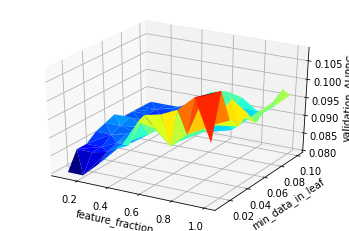

In [157]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(
    hyp_grid['feature_fraction']
    ,hyp_grid['min_data_in_leaf']
    ,hyp_grid['validation_AUPRC']
    ,cmap=cm.jet
    ,linewidth=0.2
)
ax.set_xlabel('feature_fraction')
ax.set_ylabel('min_data_in_leaf')
ax.set_zlabel('validation_AUPRC')
plt.show()

In [158]:
# Optimum using the validation set
hyp_grid.iloc[hyp_grid['validation_AUPRC'].idxmax()]

feature_fraction    1.000
min_data_in_leaf    0.020
validation_AUPRC    0.108
Name: 91, dtype: float64

# Future work

* Compare to additional algorithms
* Try dimension reduction (e.g., PCA)
* Validate local findings (e.g., feature importance) with related literature
* Extend the hyper-parameter optimization
* Add visualization to the EDA stage
* Look for correlation among the predictors (including categorical)
* Show and discuss feature importance